In [1]:
# image segmentation
import os
import gc
import random
import utils
import numpy as np
import tifffile as tif
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from model import simple_unet

np.set_printoptions(precision = 2)
np.set_printoptions(suppress  = True)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
img  = tif.imread('data/multi_recorte_1.tif')
mask = mpimg.imread('data/multi_recorte_1.png')[:,:,0]
mask = utils.convert_8bits(mask)

images_path = 'images/'
masks_path  = 'masks/'

In [4]:
utils.remove_files('images')
utils.remove_files('masks')

Todos los archivos en images han sido eliminados.
Todos los archivos en masks han sido eliminados.


In [5]:
# Parameters
Nx, Ny, Nz = img.shape
Nw   = 256
step = 100

# Index images
indx_x = np.unique(np.concatenate(([np.arange(0, Nx-Nw, step)], [np.array([Nx-Nw])]), axis = 1))
indx_y = np.unique(np.concatenate(([np.arange(0, Ny-Nw, step)], [np.array([Ny-Nw])]), axis = 1))

# Total images
N      = indx_x.size*indx_y.size

# Cut images and save them
cntr   = 0
X_test = np.zeros((N, Nw, Nw, Nz))
for i in indx_x:
    for j in indx_y:
        cntr  += 1
        i_idx = np.arange(i, i+Nw)
        j_idx = np.arange(j, j+Nw)
        img_block = img[i_idx[:, None], j_idx[None, :], :]
        img_block = utils.convert_8bits(img_block)
        mask_block = mask[i_idx[:, None], j_idx[None, :]]
        plt.imsave(images_path + str(cntr) +'.png', img_block) 
        plt.imsave(masks_path + str(cntr) +'.png', mask_block, cmap = 'gray') 

In [6]:
images_paths = sorted(
    [os.path.join(images_path, fname)
     for fname in os.listdir(images_path)
     if fname.endswith(".png")]
)

masks_paths = sorted(
    [os.path.join(masks_path, fname)
     for fname in os.listdir(masks_path)
     if fname.endswith(".png") and not fname.startswith(".")]
)

train_images_paths = images_paths
train_masks_paths  = masks_paths

img_height    = 256
img_width     = 256
img_channels  = 3

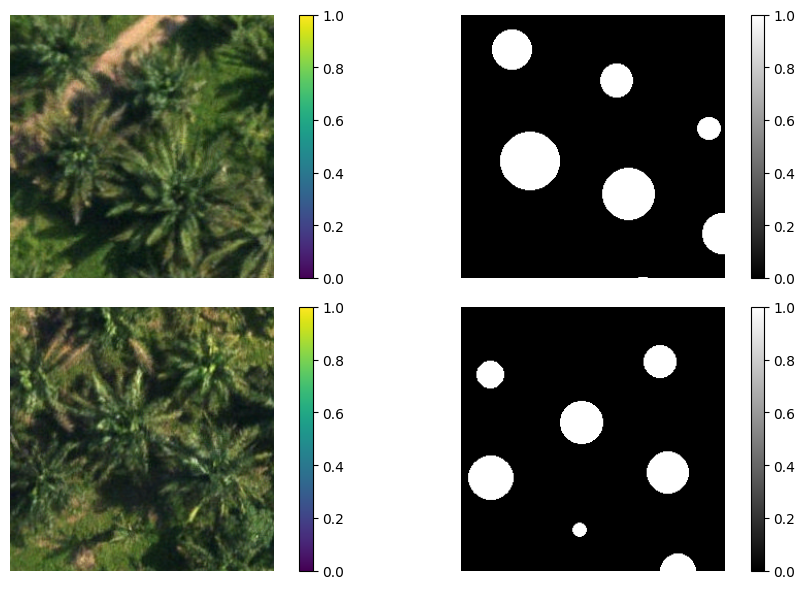

In [7]:
X_train = np.zeros((len(train_images_paths), img_height, img_width, img_channels), dtype= 'float32')
Y_train = np.zeros((len(train_masks_paths), img_height, img_width, 1), dtype = np.bool_)

for i in range(len(train_images_paths)):   
    img = mpimg.imread(train_images_paths[i])[:,:,:img_channels] 
    img = utils.normalize(img)
    X_train[i] = img  #Fill empty X_train with values from img

    
for i in range(len(train_masks_paths)):   
    img = mpimg.imread(train_masks_paths[i])[:,:,0] 
    img = (img > np.max(np.unique(img))/2).astype(np.bool_)
    img = np.expand_dims(img, axis=2)
    Y_train[i] = img  #Fill empty Y_train with values from img 


# Show trainning images
fig, axs = plt.subplots(2,2, figsize = (10, 6))

h1 = axs[0, 0].imshow(X_train[0])
plt.colorbar(h1, ax = axs[0, 0])
axs[0, 0].axis('off')

h2 = axs[0, 1].imshow(Y_train[0], cmap = 'gray')
plt.colorbar(h2, ax = axs[0, 1])
axs[0, 1].axis('off')


h3 = axs[1, 0].imshow(X_train[1])
plt.colorbar(h3, ax = axs[1, 0])
axs[1, 0].axis('off')

h4 = axs[1, 1].imshow(Y_train[1], cmap = 'gray')
plt.colorbar(h4, ax = axs[1, 1])
axs[1, 1].axis('off')


fig.tight_layout()
plt.show()

In [8]:
model = simple_unet((img_height, img_width, img_channels), n_filt = 4)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
#callbacks
#with tf.device('/cpu:0'):
results = model.fit(X_train, Y_train,
                                 validation_split = 0.1,
                                 epochs           = 150)


model.save('model_segmentation.h5')

tf.keras.backend.clear_session()
gc.collect()

Epoch 1/150
12/12 [==============================] - 10s 468ms/step - loss: 0.6778 - accuracy: 0.8917 - val_loss: 0.6730 - val_accuracy: 0.9427
Epoch 2/150
12/12 [==============================] - 3s 276ms/step - loss: 0.6680 - accuracy: 0.8770 - val_loss: 0.6623 - val_accuracy: 0.9319
Epoch 3/150
12/12 [==============================] - 3s 276ms/step - loss: 0.6366 - accuracy: 0.8358 - val_loss: 0.6274 - val_accuracy: 0.8673
Epoch 4/150
12/12 [==============================] - 3s 276ms/step - loss: 0.5365 - accuracy: 0.8162 - val_loss: 0.4935 - val_accuracy: 0.8456
Epoch 5/150
12/12 [==============================] - 3s 276ms/step - loss: 0.4656 - accuracy: 0.8355 - val_loss: 0.4528 - val_accuracy: 0.8988
Epoch 6/150
12/12 [==============================] - 3s 275ms/step - loss: 0.4348 - accuracy: 0.8640 - val_loss: 0.4527 - val_accuracy: 0.9401
Epoch 7/150
12/12 [==============================] - 3s 276ms/step - loss: 0.4170 - accuracy: 0.8798 - val_loss: 0.4148 - val_accuracy: 0.942

1466

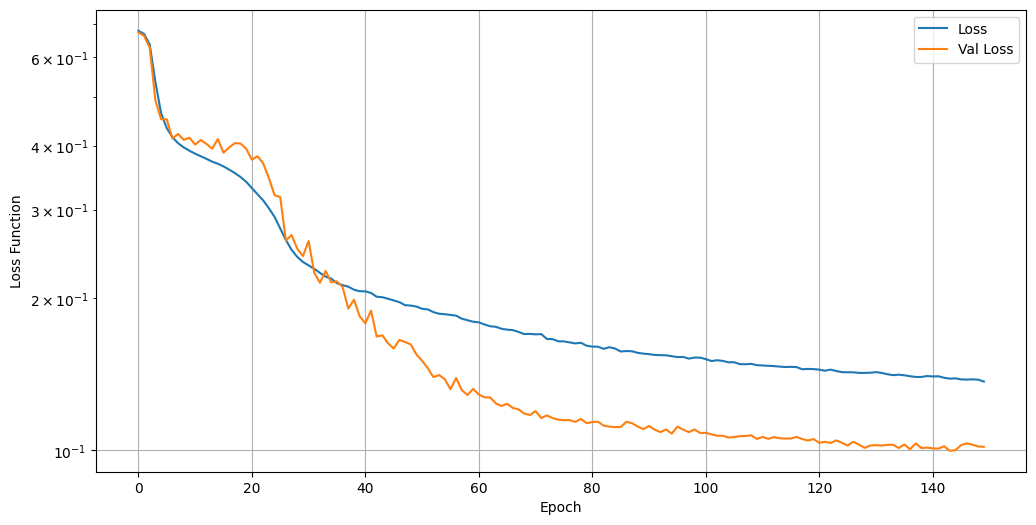

In [10]:
plt.figure(figsize=(12,6))
plt.semilogy(results.history['loss'], label = 'Loss')
plt.semilogy(results.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Function')
plt.legend()
plt.grid('on')
plt.show()